#Allowing Import from Parent Directory

In [2]:
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

#Importing Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tools.loaddata as loaddata
import tools.dataassimilation as da
import tools.visualisation as visual

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

#Loading and reshaping data

In [ ]:
path_train = "../data/train/"
path_test = "../data/test/"
path_back = "../data/background/"
path_obs = "../data/satellite/"

In [3]:
train_full, test, model_data, satellite_data = loaddata.load_all_data(path_train, path_test, path_back, path_obs)

In [4]:
train = train_full[0:1200]

In [5]:
print(f"Train data before reshaping: {np.shape(train)}")
print(f"Test data before reshaping: {np.shape(test)}")
print(f"background data before reshaping: {np.shape(model_data)}")
print(f"observational data before reshaping: {np.shape(satellite_data)}")

Train data before reshaping: (1200, 871, 913)
Test data before reshaping: (300, 871, 913)
background data before reshaping: (5, 871, 913)
observational data before reshaping: (5, 871, 913)


In [6]:
train_1D, test_1D, model_data_1D, satellite_data_1D = loaddata.reshape_all_datasets(train, test, model_data, satellite_data)

In [7]:
print(f"Train data after reshaping: {train_1D.shape}")
print(f"Test data after reshaping: {test_1D.shape}")
print(f"Model data after reshaping: {model_data_1D.shape}")
print(f"Observational data after reshaping: {satellite_data_1D.shape}")

Train data after reshaping: (1200, 795223)
Test data after reshaping: (300, 795223)
Model data after reshaping: (5, 795223)
Observational data after reshaping: (5, 795223)


# Linear Autoencoder

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=50,
                                               verbose=2,
                                               restore_best_weights=True)

In [9]:
encoder = keras.models.Sequential([keras.layers.Dense(15, input_shape=[795223], activation="linear")])
decoder = keras.models.Sequential([keras.layers.Dense(795223, input_shape=[15], activation="linear")])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
                    )
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 15)                11928360  
                                                                 
 sequential_1 (Sequential)   (None, 795223)            12723568  
                                                                 
Total params: 24,651,928
Trainable params: 24,651,928
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = autoencoder.fit(train_1D, 
                          train_1D, 
                          epochs=20,
                          validation_data=(train_1D, train_1D),
                          callbacks=[early_stopping])

Epoch 1/20
38/38 [==============================] - 9s 208ms/step - loss: 0.1573 - val_loss: 0.0386
Epoch 2/20
38/38 [==============================] - 7s 185ms/step - loss: 0.0286 - val_loss: 0.0191
Epoch 3/20
38/38 [==============================] - 7s 184ms/step - loss: 0.0174 - val_loss: 0.0151
Epoch 4/20
38/38 [==============================] - 7s 186ms/step - loss: 0.0144 - val_loss: 0.0134
Epoch 5/20
38/38 [==============================] - 7s 190ms/step - loss: 0.0132 - val_loss: 0.0125
Epoch 6/20
38/38 [==============================] - 7s 188ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 7/20
38/38 [==============================] - 7s 188ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 8/20
38/38 [==============================] - 7s 188ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 9/20
38/38 [==============================] - 7s 187ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 10/20
38/38 [==============================] - 7s 189ms/step - loss: 0.0116 - val_loss: 0.0113

dict_keys(['loss', 'val_loss'])
best value:  0.011890673078596592


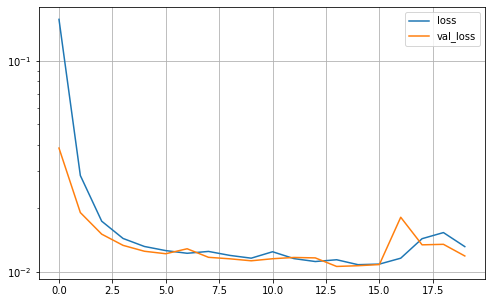

In [11]:
print(history.history.keys())
print('best value: ', autoencoder.evaluate(train_1D, train_1D, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [12]:
test_recovered = autoencoder.predict(test_1D)
mse_test = da.mse(test_1D, test_recovered)
print('mse: ', mse_test)

mse:  0.011044955676303942


#Data Assimilation - Kalman Filter (BLUE)

In [13]:
model_data_compr = encoder.predict(model_data_1D)
satellite_data_compr = encoder.predict(satellite_data_1D)

latent_space = satellite_data_compr.shape[1]
nNodes = latent_space  # latent_space is the size of the compressed variables or number of principal components used
I = np.identity(nNodes)
R = np.cov(satellite_data_compr.T)
H = I 
B = 0.001 * I

In [14]:
## Performing data assimilation
updated_data_array = da.assimilate(B, H, R, model_data_compr, satellite_data_compr)

## Printing MSE in latent space
mse_before_DA = da.mse(satellite_data_compr, model_data_compr)
mse_after_DA = da.mse(satellite_data_compr, updated_data_array)
print('MSE before assimilation in latent space: ', mse_before_DA )
print('MSE after assimilation in latent space: ', mse_after_DA)

## Printing MSE in Physical space space
updated_data_recon = decoder.predict(updated_data_array)
mse_before_DA_physical = da.mse(satellite_data_1D, model_data_1D)
mse_after_DA_physical = da.mse(satellite_data_1D, updated_data_recon)

print('MSE before assimilation in physical space: ', mse_before_DA_physical)
print('MSE after assimilation in physical space: ', mse_after_DA_physical)

MSE before assimilation in latent space:  813.7622
MSE after assimilation in latent space:  325.128050404119
MSE before assimilation in physical space:  0.1191695914227833
MSE after assimilation in physical space:  0.07752281741861795


#Visualising Results 

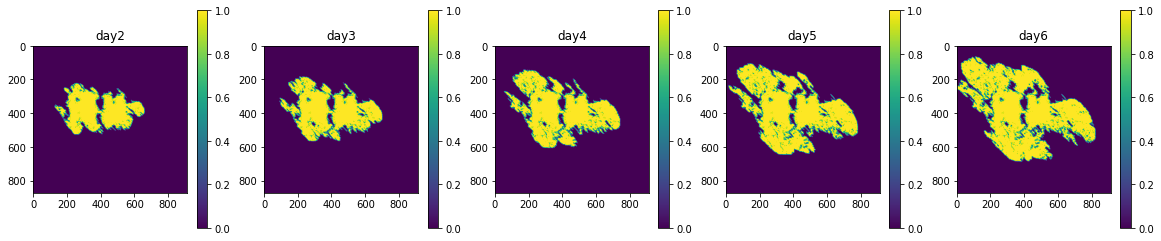

In [15]:
# Plot model data
visual.plot_data(model_data)

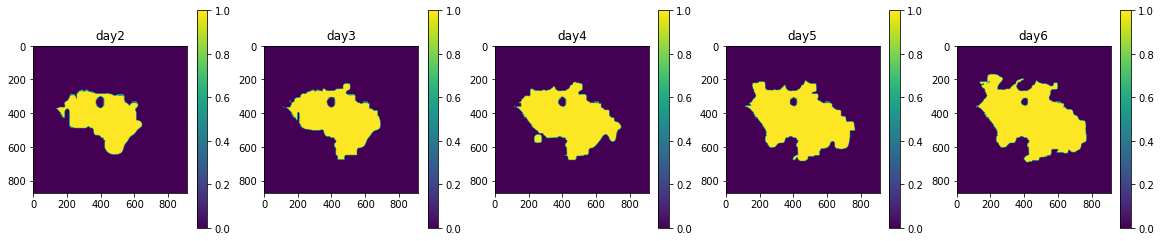

In [16]:
# Plot satellite data 
visual.plot_data(satellite_data)

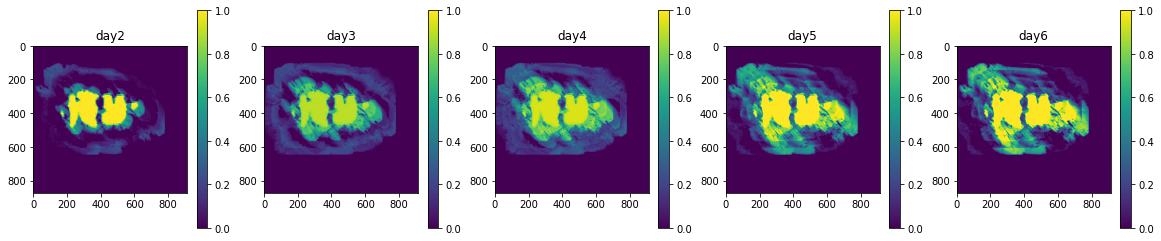

In [17]:
# Plot reconstructed model
updated_data_recon = np.reshape(updated_data_recon, (5, 871, 913))
visual.plot_data(updated_data_recon)